In [1]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
import os

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - loss: 0.0520 - val_loss: 0.0498
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 496ms/step - loss: 0.0449 - val_loss: 0.0391
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 486ms/step - loss: 0.0331 - val_loss: 0.0195
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 490ms/step - loss: 0.0160 - val_loss: 0.0110
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 491ms/step - loss: 0.0108 - val_loss: 0.0087
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 555ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 479ms/step - loss: 0.0081 - val_loss: 0.0073
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step - loss: 0.0068 - val_loss: 0.0063
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0062
Test MSE: 0.0063490369357168674
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


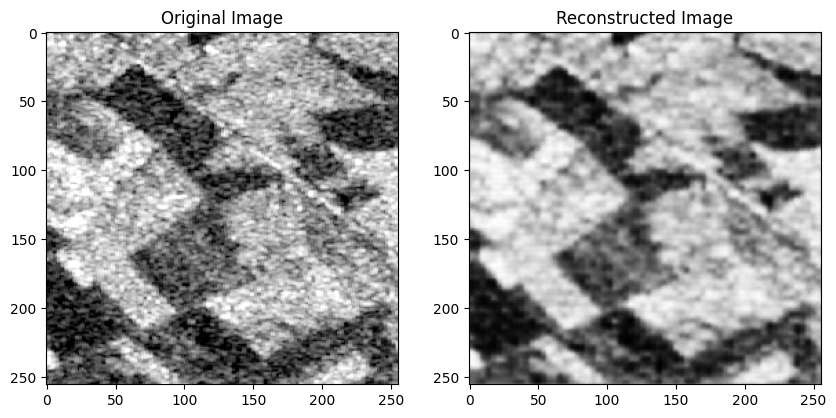

In [3]:


# Define the custom dataset class
class CustomDataset:
    def __init__(self, dataset_path, categories, sets):
        self.dataset_path = dataset_path
        self.categories = categories
        self.sets = sets
        self.images = {category: {set_name: [] for set_name in sets} for category in categories}

        for category in categories:
            for set_name in sets:
                folder_path = os.path.join(dataset_path, category, set_name)
                if os.path.isdir(folder_path):
                    for image_file in os.listdir(folder_path):
                        image_path = os.path.join(folder_path, image_file)
                        if os.path.isfile(image_path):
                            try:
                                image = cv2.imread(image_path)
                                if image is not None:
                                    self.images[category][set_name].append(image)
                                else:
                                    print(f"Failed to load image {image_file} in {category}/{set_name}")
                            except Exception as e:
                                print(f"Error loading image {image_file} in {category}/{set_name}. Error: {e}")

    def get_images(self):
        images = []
        for category in self.categories:
            for set_name in self.sets:
                for image in self.images[category][set_name]:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    image = image / 255.0
                    images.append(image)
        return np.array(images)

# Load the custom dataset
dataset_path = "C:\\Users\\admin\\Downloads\\SIH"
categories = ["agri", "barrenland"]
sets = ["s1", "s2"]
custom_dataset = CustomDataset(dataset_path, categories, sets)

# Split the dataset into training and testing sets
X = custom_dataset.get_images()
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Define the autoencoder model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, output_layer)

# Compile the model
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
autoencoder.fit(X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1), X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1), epochs=10, batch_size=32, validation_data=(X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1), X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)))

# Evaluate the model
mse = autoencoder.evaluate(X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1), X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1))
print(f"Test MSE: {mse}")

# Visualize the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(autoencoder.predict(X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1))[0], cmap='gray')
plt.title('Reconstructed Image')

plt.show()

